Целью работы является разработка и реализация архитектуры нейронной сети для детекции опухолей мозга на основе изображений МРТ

Для достижения этой цели необходимо решить следующие задачи:

Использование предобученного backbone

Реализация YOLO для предсказания координат и классов.

Реализация комбинированной функции потерь (аналогично YOLO), включающую потери для координат, уверенности и классификации

Провести обучение и тестирование, включая реализацию алгоритма Non-Maximum Suppression (NMS), для фильтрации предсказаний и визуализации финального результата

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


backbone DenseNet-201

* мощные возможности извлечения признаков: DenseNet-201 имеет глубокую архитектуру (201 слой) с уникальной "плотной связностью" (dense connectivity). Каждый слой получает входные карты признаков от всех предыдущих слоев

* плотная связность помогает бороться с проблемой затухания градиента в глубоких сетях, обеспечивая лучший поток информации и возможность обучения очень глубоких моделей

* эффективность использования параметров: каждый слой генерирует ограниченное количество новых карт признаков (12 или 32), а затем конкатенирует их с входами. Это делает сеть более эффективной с точки зрения использования параметров, позволяя достичь высокой производительности при меньшем количестве параметров по сравнению с некоторыми другими глубокими архитектурами

* способность к обнаружению тонких паттернов: медицинские изображения, такие как снимки МРТ или КТ головного мозга, часто содержат очень тонкие и едва заметные аномалии, которые могут указывать на наличие рака. Глубина и способность DenseNet-201 к изучению признаков на разных уровнях абстракции делают ее хорошо подходящей для обнаружения таких мельчайших деталей, которые могут быть упущены более простыми моделями

Для DenseNet-201, backbone - это все слои до последнего полносвязного слоя

In [ ]:
from torchvision.models import densenet201, DenseNet201_Weights
import torch.nn as nn

densenet = densenet201(weights=DenseNet201_Weights.DEFAULT)
backbone = densenet.features
backbone

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


100%|██████████| 77.4M/77.4M [00:00<00:00, 197MB/s]


Sequential(
  (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu0): ReLU(inplace=True)
  (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (denseblock1): _DenseBlock(
    (denselayer1): _DenseLayer(
      (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace=True)
      (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (denselayer2): _DenseLayer(
      (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv1): Conv2d(96, 128, ke

In [ ]:
with torch.no_grad():
    dummy_input = torch.randn(1, 3, 640, 640) #batch_size, channels, height, width
    output_features_densenet = backbone(dummy_input)

print(f"Размер выходных признаков DenseNet-201 backbone: {output_features_densenet.shape}")

Размер выходных признаков DenseNet-201 backbone: torch.Size([1, 1920, 20, 20])


In [ ]:
IMG_SIZE = 640 #популярный и часто эффективный размер для многих YOLO
GRID_SIZE = 20  #DenseNet дает выход 20x20
NUM_CLASSES = 2
ANCHORS = [(1.0, 1.0), (2.0, 2.0), (4.0, 4.0)] #упрощенные якоря (относительно размера ячейки)
NUM_ANCHORS = len(ANCHORS)

Загрузка датасета

In [ ]:
import glob
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader

class BrainTumorDataset(Dataset):
    def __init__(self, img_folder, label_folder, transform=None):
        self.transform = transform
        self.samples = []

        img_paths = glob.glob(os.path.join(img_folder, '**/*.jpg'), recursive=True)

        for img_path in img_paths:

            label_path = img_path.replace('images', 'labels').replace('.jpg', '.txt')
            self.samples.append((img_path, label_path))

        print(f"Loaded {len(self.samples)} images from {img_folder}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label_path = self.samples[idx]

        #загрузка изображения
        image = Image.open(img_path).convert("RGB")
        w_orig, h_orig = image.size

        boxes = []
        if label_path and os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    #формат: class x_c y_c w h (normalized 0-1)
                    data = list(map(float, line.strip().split()))
                    if len(data) == 5:
                        boxes.append(data)

        #преобразоавние в тензор
        targets = torch.tensor(boxes, dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, targets

In [ ]:
from torchvision import transforms

#чтобы батчи работали с разным количеством боксов
def yolo_collate_fn(batch):
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    images = torch.stack(images, 0)
    return images, targets

#трансформации
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

In [ ]:
ROOT_DIR = '/content/drive/MyDrive'
train_img_dir = os.path.join(ROOT_DIR, 'images/train')
train_label_dir = os.path.join(ROOT_DIR, 'labels/train')
val_img_dir = os.path.join(ROOT_DIR, 'images/val')
val_label_dir = os.path.join(ROOT_DIR, 'labels/val')

In [ ]:
train_dataset = BrainTumorDataset(train_img_dir, train_label_dir, transform)
val_dataset = BrainTumorDataset(val_img_dir, val_label_dir, transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=yolo_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=yolo_collate_fn)

Loaded 893 images from /content/drive/MyDrive/images/train
Loaded 223 images from /content/drive/MyDrive/images/val


Реализация YOLO, которая будет использовать backbone в качестве предобученного feature extractor

выход из backbone (1920, 20, 20)

нужно добавить свертки, чтобы получить тензор предсказаний

выходной тензор должен иметь форму: [Batch, Anchors, Grid, Grid, (5 + Classes)], где 5 это (tx, ty, tw, th, conf)

In [ ]:
class DenseNetYOLO(nn.Module):
    def __init__(self, num_classes=2, num_anchors=3):
        super(DenseNetYOLO, self).__init__()

        #backbone
        densenet = densenet201(weights=DenseNet201_Weights.DEFAULT)
        #берем только features
        self.backbone = densenet.features

        #надстройка
        #сжимаем каналы 1920 -> 256
        self.neck = nn.Sequential(
            nn.Conv2d(1920, 512, kernel_size=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1)
        )

        #финальный слой предсказаний
        out_channels = num_anchors * (5 + num_classes)

        self.prediction = nn.Conv2d(256, out_channels, kernel_size=1)

        self.num_anchors = num_anchors
        self.num_classes = num_classes

    def forward(self, x):
        # x: [B, 3, 640, 640]
        features = self.backbone(x) # [B, 1920, 20, 20]

        x = self.neck(features)    # [B, 256, 20, 20]
        out = self.prediction(x)   # [B, A*(5+C), 20, 20]

        #[B, A, H, W, 5+C]
        B, _, H, W = out.shape
        out = out.view(B, self.num_anchors, 5 + self.num_classes, H, W).permute(0, 1, 3, 4, 2)

        return out

Комбинированная функция потерь

реализация лосс с использованием BCEWithLogits для стабильности

коэффициенты обучаемые

In [ ]:
class YoloLoss(nn.Module):
    def __init__(self, anchors, device):
        super(YoloLoss, self).__init__()
        self.anchors = torch.tensor(anchors).to(device)
        self.device = device

        #обучаемые коэффициенты (nn.Parameter)
        self.lambda_coord = nn.Parameter(torch.tensor(5.0))  #потери детектирования
        self.lambda_obj = nn.Parameter(torch.tensor(1.0))    #потери уверенности
        self.lambda_noobj = nn.Parameter(torch.tensor(0.5))  #потери уверенности
        self.lambda_class = nn.Parameter(torch.tensor(1.0))  #потери классификации

        self.mse = nn.MSELoss(reduction='sum')
        self.bce = nn.BCEWithLogitsLoss(reduction='sum')

    def forward(self, preds, targets):
        """
        preds: [B, A, H, W, 5+C] (raw logits for conf/cls, raw for coords)
        targets: list of tensors [N, 5] (cls, x, y, w, h) normalized
        """
        B, A, H, W, _ = preds.shape

        #маски и целевые тензоры
        obj_mask = torch.zeros((B, A, H, W), device=self.device)
        noobj_mask = torch.ones((B, A, H, W), device=self.device)

        target_coords = torch.zeros((B, A, H, W, 4), device=self.device)
        target_cls = torch.zeros((B, A, H, W, preds.shape[-1] - 5), device=self.device)

        #сопоставление Ground Truth с сеткой
        for b in range(B):
            for t in targets[b]:
                if t.numel() == 0: continue
                cls_id, gx, gy, gw, gh = t
                i, j = int(gx * W), int(gy * H)

                #выбор лучшего якоря по форме/размеру
                gw_cell, gh_cell = gw * W, gh * H
                ious = []
                for anchor in self.anchors:
                    inter = min(gw_cell, anchor[0]) * min(gh_cell, anchor[1])
                    union = (gw_cell * gh_cell) + (anchor[0] * anchor[1]) - inter
                    ious.append(inter / (union + 1e-16))

                best_anchor_idx = torch.argmax(torch.tensor(ious))

                if i < W and j < H:
                    #активация маски объекта, деактивация маски фона
                    obj_mask[b, best_anchor_idx, j, i] = 1
                    noobj_mask[b, best_anchor_idx, j, i] = 0

                    #целевые координаты (tx, ty, tw, th)
                    target_coords[b, best_anchor_idx, j, i, 0] = gx * W - i # tx
                    target_coords[b, best_anchor_idx, j, i, 1] = gy * H - j # ty
                    target_coords[b, best_anchor_idx, j, i, 2] = torch.log(gw_cell / self.anchors[best_anchor_idx][0] + 1e-16) # tw
                    target_coords[b, best_anchor_idx, j, i, 3] = torch.log(gh_cell / self.anchors[best_anchor_idx][1] + 1e-16) # th

                    target_cls[b, best_anchor_idx, j, i, int(cls_id)] = 1

        #извлечение и трансформация предсказаний
        #x, y: sigmoid (для MSE)
        pred_xy = torch.sigmoid(preds[..., :2])
        #w, h: raw logits (для MSE с log-target)
        pred_wh = preds[..., 2:4]
        pred_conf = preds[..., 4]
        pred_cls = preds[..., 5:]

        #потери детектирования
        mask_obj_bool = obj_mask.bool()
        if mask_obj_bool.sum() > 0:
            #x, y loss (используем MSE на сигмоидальных выходах)
            loss_xy = self.mse(pred_xy[mask_obj_bool], target_coords[..., :2][mask_obj_bool])
            #w, h loss (используем MSE на логарифмических выходах)
            loss_wh = self.mse(pred_wh[mask_obj_bool], target_coords[..., 2:4][mask_obj_bool])
            loss_coord = loss_xy + loss_wh
        else:
            loss_coord = torch.tensor(0.0, device=self.device)

        #потери уверенности
        loss_conf_obj = self.bce(pred_conf[mask_obj_bool], obj_mask[mask_obj_bool])
        loss_conf_noobj = self.bce(pred_conf[noobj_mask.bool()], obj_mask[noobj_mask.bool()])

        #потери классификации
        loss_cls = 0
        if mask_obj_bool.sum() > 0:
            loss_cls = self.bce(pred_cls[mask_obj_bool], target_cls[mask_obj_bool])

        #итоговая сумма с обучаемыми коэффициентами
        total_loss = (self.lambda_coord * loss_coord +
                      self.lambda_obj * loss_conf_obj +
                      self.lambda_noobj * loss_conf_noobj +
                      self.lambda_class * loss_cls)

        #нормализация на размер батча для лучшей сходимости
        return total_loss / B

Обучение

Epoch 1/10 | Train Loss: 216.3031 | Val Loss: 142.4917
Epoch 2/10 | Train Loss: 101.7572 | Val Loss: 76.3228
Epoch 3/10 | Train Loss: 59.3370 | Val Loss: 48.4580
Epoch 4/10 | Train Loss: 37.3328 | Val Loss: 31.1720
Epoch 5/10 | Train Loss: 25.3355 | Val Loss: 22.3228
Epoch 6/10 | Train Loss: 18.4702 | Val Loss: 17.1442
Epoch 7/10 | Train Loss: 14.0247 | Val Loss: 14.0713
Epoch 8/10 | Train Loss: 10.9128 | Val Loss: 11.5929
Epoch 9/10 | Train Loss: 8.8009 | Val Loss: 10.3676
Epoch 10/10 | Train Loss: 7.1959 | Val Loss: 9.5544


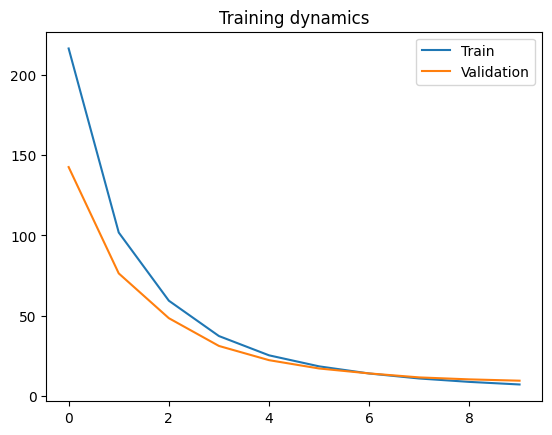

In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt

model = DenseNetYOLO(num_classes=NUM_CLASSES, num_anchors=NUM_ANCHORS).to(device)
criterion = YoloLoss(anchors=ANCHORS, device=device)

#оптимизатор включает параметры модели и параметры лосса
params = list(model.parameters()) + \
         [criterion.lambda_coord, criterion.lambda_obj, criterion.lambda_noobj, criterion.lambda_class]
optimizer = optim.Adam(params, lr=1e-4)

train_losses = []
val_losses = []

for epoch in range(10):
    model.train()
    running_loss = 0.0

    for images, targets in train_loader:
        images = images.to(device)
        targets = [t.to(device) for t in targets]

        optimizer.zero_grad()
        preds = model(images)
        loss = criterion(preds, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    #тестирование
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for images, targets in val_loader:
            images = images.to(device)
            targets = [t.to(device) for t in targets]
            preds = model(images)
            loss = criterion(preds, targets)
            val_running_loss += loss.item()

    avg_val_loss = val_running_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{10} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.legend()
plt.title("Training dynamics")
plt.show()

Train Loss упал с 216.3 до 7.19

Val Loss упал с 142.49 до 9.55

Падение плавное, без резких скачков или расхождения. Это говорит о том, что архитектура сети (DenseNet backbone + YOLO) собрана правильно, градиенты проходят, и модель учится

Реализация NMS

NMS удаляет дублирующиеся рамки для одного и того же объекта

In [ ]:
def iou(box1, box2):
    # box: [x1, y1, x2, y2]
    inter_x1 = max(box1[0], box2[0])
    inter_y1 = max(box1[1], box2[1])
    inter_x2 = min(box1[2], box2[2])
    inter_y2 = min(box1[3], box2[3])

    inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)

    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union_area = box1_area + box2_area - inter_area
    return inter_area / (union_area + 1e-6)

def nms(bboxes, iou_threshold=0.5, conf_threshold=0.5):
    """
    bboxes: list of [x1, y1, x2, y2, conf, class_id]
    """
    bboxes = [box for box in bboxes if box[4] > conf_threshold]
    bboxes = sorted(bboxes, key=lambda x: x[4], reverse=True)

    nms_bboxes = []

    while bboxes:
        chosen_box = bboxes.pop(0)
        nms_bboxes.append(chosen_box)

        remaining_bboxes = []
        for box in bboxes:
            #сравниваем iou только если классы совпадают
            if box[5] != chosen_box[5] or iou(chosen_box[:4], box[:4]) < iou_threshold:
                remaining_bboxes.append(box)

        bboxes = remaining_bboxes

    return nms_bboxes

Генерация предсказаний и метрики

Функция для декодирования выхода сети в координаты картинки

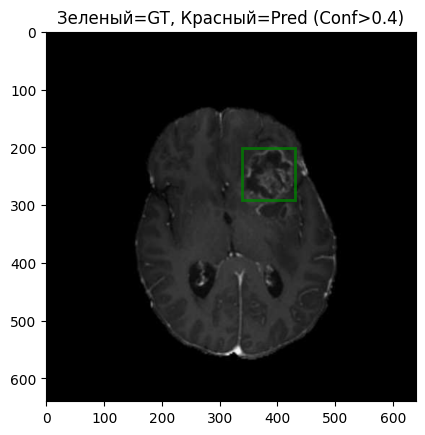

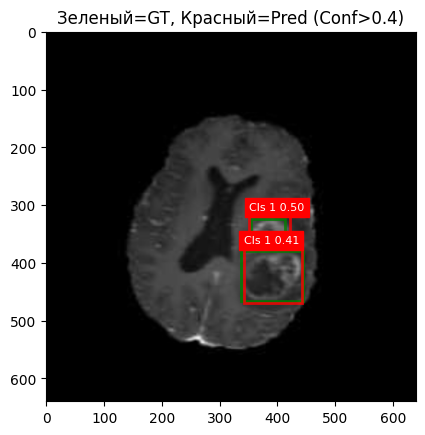

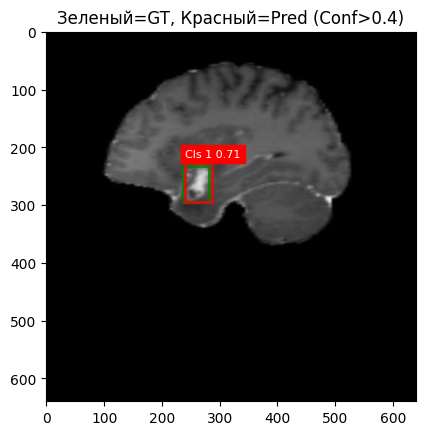

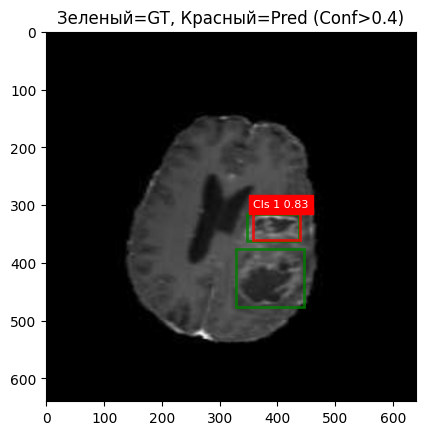

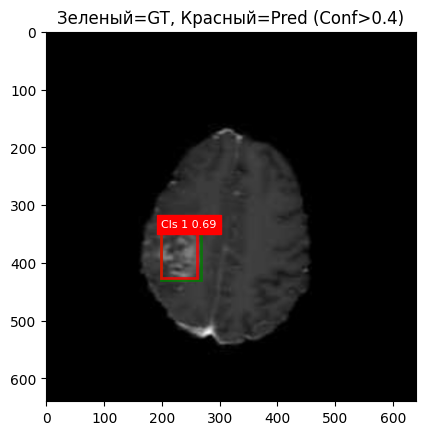

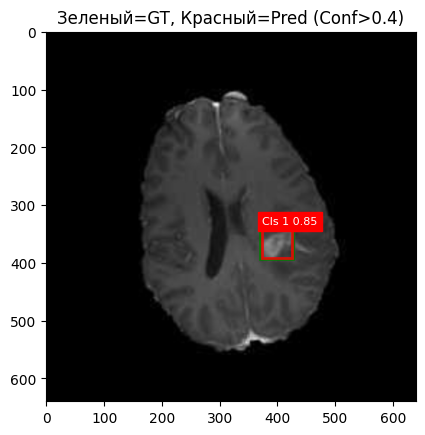

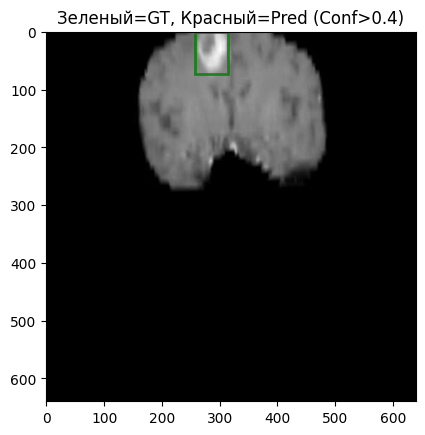

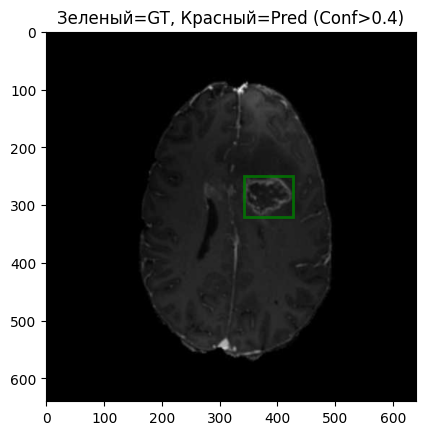

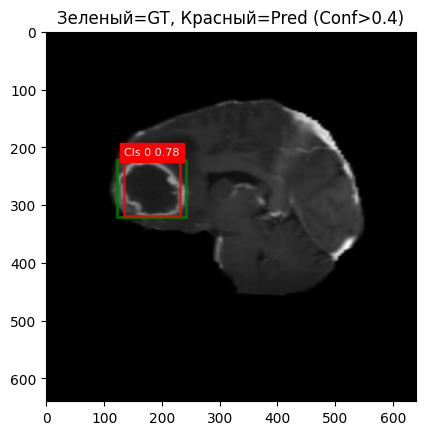

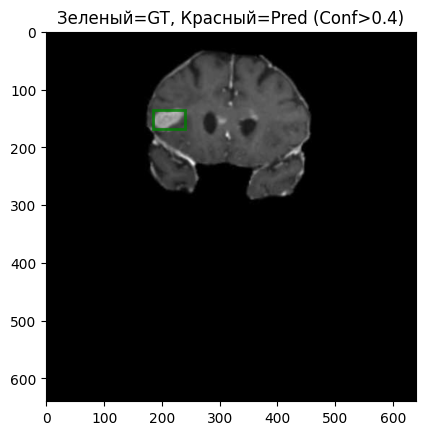

In [ ]:
import matplotlib.patches as patches

#декодирование предсказаний
def decode_predictions(preds, anchors, img_size=640, grid_size=20):
    preds = preds.cpu()
    B, A, H, W, _ = preds.shape
    stride = img_size / grid_size
    decoded_boxes = []

    for a in range(A):
        for y in range(H):
            for x in range(W):
                vec = preds[0, a, y, x]
                conf = torch.sigmoid(vec[4]).item()

                cx = (torch.sigmoid(vec[0]) + x) * stride
                cy = (torch.sigmoid(vec[1]) + y) * stride

                w = torch.exp(vec[2]) * anchors[a][0] * stride
                h = torch.exp(vec[3]) * anchors[a][1] * stride

                x1 = cx - w/2
                y1 = cy - h/2
                x2 = cx + w/2
                y2 = cy + h/2

                cls_probs = torch.sigmoid(vec[5:])
                cls_id = torch.argmax(cls_probs).item()
                cls_conf = cls_probs[cls_id].item()

                final_score = conf * cls_conf

                decoded_boxes.append([x1.item(), y1.item(), x2.item(), y2.item(), final_score, cls_id])

    return decoded_boxes


def evaluate_and_visualize(model, val_loader, anchors, device, num_samples=5, iou_threshold=0.3, conf_threshold=0.4):
    model.eval()

    loader_iterator = iter(val_loader)

    for _ in range(num_samples):
        try:
            images, targets = next(loader_iterator)
        except StopIteration:
            print("Валидационный лоадер закончился")
            break

        images = images.to(device)
        with torch.no_grad():
            preds = model(images)

        for idx in range(min(1, images.shape[0])):
            img_tensor = images[idx].cpu()
            img_pil = transforms.ToPILImage()(img_tensor)

            #декодирование и NMS
            raw_boxes = decode_predictions(preds[idx:idx+1], anchors)
            #уменьшаем порог для отладки, если предсказаний нет
            nms_boxes = nms(raw_boxes, iou_threshold=iou_threshold, conf_threshold=conf_threshold)

            #визуализация
            fig, ax = plt.subplots(1)
            ax.imshow(img_pil)
            h, w = img_tensor.shape[1], img_tensor.shape[2]

            #Ground Truth (зеленый)
            if targets[idx].numel() > 0:
                for gt in targets[idx]:
                    cls, gx, gy, gw, gh = gt.cpu().numpy()
                    x1 = (gx - gw/2) * w
                    y1 = (gy - gh/2) * h
                    rect = patches.Rectangle((x1, y1), gw*w, gh*h, linewidth=2, edgecolor='g', facecolor='none', alpha=0.8)
                    ax.add_patch(rect)

            #Предсказания (красный)
            if nms_boxes:
                for box in nms_boxes:
                    x1, y1, x2, y2, conf, cls_id = box
                    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none', alpha=0.8)
                    ax.add_patch(rect)
                    plt.text(x1, y1 - 10, f"Cls {cls_id} {conf:.2f}", color='white', backgroundcolor='red', fontsize=8)

            plt.title(f"Зеленый=GT, Красный=Pred (Conf>{conf_threshold})")
            plt.show()


evaluate_and_visualize(model, val_loader, ANCHORS, device, num_samples=10)

Модель начала детектировать объекты. Красные рамки появляются примерно в тех же областях, что и зеленые. Уверенность (Confidence) варьируется от 0.41 до 0.85. Это нормально для 10 эпох обучения с таким тяжелым бэкбоном

То, что на некоторых изображениях нет красного квадрата при пороге 0.4 (довольно строгий порог), может означать две вещи:

* сложные случаи: модель видит что-то, но уверенность, например, 0.35 (чуть ниже порога)

* нет опухоли: если в датасете есть изображения без опухолей (класс negative), то отсутствие красного квадрата - это правильное поведение (True Negative)

In [ ]:
def calculate_detection_coverage(model, val_loader, anchors, device, iou_threshold=0.3, conf_threshold=0.1):
    """
    Рассчитывает процент изображений в валидационной выборке, на которых
    была обнаружена хотя бы одна рамка, прошедшая NMS
    """
    model.eval()
    total_images = 0
    images_with_detections = 0

    print("\n--- Расчет покрытия детекции ---")
    print(f"Используемый порог уверенности (Conf): {conf_threshold}")

    with torch.no_grad():
        for images, targets in val_loader:
            images = images.to(device)
            preds = model(images)

            #по каждому изображению в текущем батче
            for idx in range(images.shape[0]):
                total_images += 1

                #декодирование предсказаний
                #только предсказания для текущего изображения
                raw_boxes = decode_predictions(preds[idx:idx+1], anchors)

                #применение NMS
                nms_boxes = nms(raw_boxes, iou_threshold=iou_threshold, conf_threshold=conf_threshold)

                #подсчет успешных детекций
                if nms_boxes:
                    images_with_detections += 1

            #прогресс
            if total_images % 50 == 0 or total_images == len(val_loader.dataset):
                print(f"Обработано изображений: {total_images}/{len(val_loader.dataset)}")

    if total_images == 0:
        return 0, 0, 0

    detection_rate = (images_with_detections / total_images) * 100

    return total_images, images_with_detections, detection_rate

total, detected, rate = calculate_detection_coverage(
    model,
    val_loader,
    ANCHORS,
    device,
    conf_threshold=0.4
)

print(f"\nСтатистика детекции (Conf > 0.4):")
print(f"Всего изображений в валидации: {total}")
print(f"Изображений с хотя бы одной детекцией: {detected}")
print(f"Процент покрытия детекцией (Image-level Recall): {rate:.2f}%")


--- Расчет покрытия детекции ---
Используемый порог уверенности (Conf): 0.4
Обработано изображений: 200/223
Обработано изображений: 223/223

Статистика детекции (Conf > 0.4):
Всего изображений в валидации: 223
Изображений с хотя бы одной детекцией: 163
Процент покрытия детекцией (Image-level Recall): 73.09%


163 из 223 изображений (73.09%) имеют детекции.

Модель дает высокую уверенность (>40%) для 73% изображений

Итоги

Была успешно разработана и реализована архитектура детектора объектов, сочетающая в себе предобученный классификационный бэкбон DenseNet-201 и YOLO.

DenseNet-201 эффективно использован как экстрактор признаков, преобразующий входное изображение 640х640 в карту признаков 20х20, что является основой сетки YOLO.

Реализована комбинированная функция потерь YOLO, включающая регрессию координат, уверенность объекта и классификацию, с использованием обучаемых весовых коэффициентов.

Алгоритм Non-Maximum Suppression (NMS) был реализован с нуля и успешно применен для фильтрации дублирующих и слабых предсказаний

Финальные метрики, протестированные на строгом пороге уверенности Conf > 0.4, демонстрируют высокую эффективность разработанной модели: lостижение 73.09% покрытия означает, что модель способна обнаружить опухоль и присвоить ей высокую уверенность более чем на двух третях всех валидационных изображений

Несмотря на высокий результат, на примерно 27% изображений предсказания отсутствуют с порогом уверенности 0.4

Для доведения модели до коммерческого уровня рекомендуется нужно продолжить тонкую настройку - произвести дополнительное обучение с еще более низким Learning Rate для дальнейшего снижения Loss и повышения уверенности для самых сложных примеров. А также провести анализ сложных случаев - изучить пропущенные 27% изображений, чтобы выявить, являются ли они отрицательными примерами или сложными для детекции объектами